In [118]:
import numpy as np
import sympy as sym
from scipy.integrate import solve_bvp # solve boundary value problem
from scipy.integrate import solve_ivp # solve initial value problem
from scipy.optimize import minimize
from scipy.linalg import norm
import scipy
import math
pi = math.pi
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import Image
from math import *
from scipy.interpolate import CubicSpline
from numba import jit, prange

In [119]:
nt = 7
T = 1
dt = T/(nt-1)
time = np.linspace(-1,T,nt)

In [120]:
def dynamics_2d(t, q, u):
    q1, q2, q3 = q 
    dq1dt = np.cos(q3)
    dq2dt = np.sin(q3)
    dq3dt = u(t)

    dqdt = [dq1dt, dq2dt, dq3dt]
    return dqdt

x value [0.         0.05305165 0.1061033  0.15915494 0.21220659 0.26525824
 0.31830989]
y value [ 0.00000000e+00  7.22222222e-01  1.27777778e+00  1.50000000e+00
  1.27777778e+00  7.22222222e-01 -3.33066907e-16]


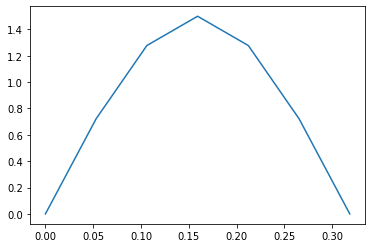

In [121]:
r = 0.5
x = np.linspace(0,1/pi,nt)
x_inter = [0,np.median(x),x[-1]]
# y_inter = [0, np.sqrt(1-np.median(x)),0]
# y_inter = [0, np.sqrt(1-np.median(x))*0.5,0]
y_inter = [0, 1.5 ,0]
f = CubicSpline(x_inter, y_inter, bc_type='natural')
# f = CubicSpline(x_inter, y_inter, bc_type='clamped')
y = f(x)
plt.plot(x,y)


#### for theta calculating
x2 = np.linspace(0,1/pi,(nt+2))
y2 = f(x2)

print('x value', x)
print('y value', y)

In [122]:
###### worked version
theta = np.zeros(nt)
for i in range(nt-1):
    dx = x[i+1] - x[i]
    dy = y[i+1] - y[i]
    theta[i+1] = atan2(dy,dx)
##### u should be size one less than theta, x andy y
u = np.zeros(nt)
for i in range(nt-1):
    u[i] = (theta[i+1] - theta[i])/dt

print(theta)
# u[-1] = u[0]
print(u)





# ##### tried version1
# theta = np.zeros(nt)
# for i in range(nt-1):
#     dx = x[i+1] - x[i]
#     dy = y[i+1] - y[i]
#     theta[i] = atan2(dy,dx)


# ##### u should be size one less than theta, x andy y
# u = np.zeros(nt)
# for i in range(nt-2):
#     u[i] = (theta[i+1] - theta[i])/dt

# print(theta)
# print(u)


# ###### tried version2
# theta = np.zeros(nt+2)
# for i in range(nt+1):
#     dx = x2[i+1] - x2[i]
#     dy = y2[i+1] - y2[i]
#     theta[i+1] = atan2(dy,dx)

# ##### u should be size one less than theta, x andy y
# u = np.zeros(nt)
# theta = theta[1:]

# for i in range(nt):
#     u[i] = (theta[i+1] - theta[i])/dt

# print(theta)
# # u[-1] = u[0]
# print(u)





[ 0.          1.49747189  1.47559205  1.33645024 -1.33645024 -1.47559205
 -1.49747189]
[  8.98483135  -0.13127907  -0.83485085 -16.03740287  -0.83485085
  -0.13127907   0.        ]


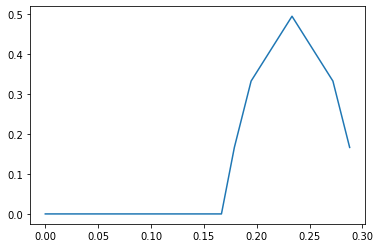

In [123]:
x_sim = np.zeros(len(x))
y_sim = np.zeros(len(y))
theta_sim = np.zeros(len(theta))
for i in range(nt-1):
        if i == 0:
            x_sim[0], y_sim[0], theta_sim[0] = x[0], y[0], theta[0]


        x_sim[i+1] = x_sim[i] +  dt*cos(theta_sim[i])
        y_sim[i+1] = y_sim[i] +  dt*sin(theta_sim[i])
        theta_sim[i+1] = theta_sim[i] + dt*u[i]



plt.plot(x_sim, y_sim)
    

In [124]:
# print(x_sim)
# print(y_sim)
# print(theta_sim)
# print(u)

[0.         0.16666667 0.17887646 0.19471988 0.23342105 0.27212221
 0.28796563]
[0.         0.         0.16621883 0.33213074 0.49424181 0.33213074
 0.16621883]
[ 0.          1.49747189  1.47559205  1.33645024 -1.33645024 -1.47559205
 -1.49747189]
[  8.98483135  -0.13127907  -0.83485085 -16.03740287  -0.83485085
  -0.13127907   0.        ]


In [125]:
####### calculating the total energy along the rod
E_before = dt*0.5*np.sum(u**2)
print(E_before)

28.279492123420173


In [126]:
# @jit(nopython=True)
def cost_function(state_initials, nt, dt):
    state_initials = state_initials.reshape((4,nt))
    u_cost = state_initials[-1,0:-1]
#     u_cost = state_initials[-1,:]
    running_cost = np.zeros((len(u_cost)))
    
    for i in prange(len(u_cost)):
        running_cost[i] = dt*0.5*(u_cost[i])**2
    cost = np.sum(np.square(running_cost))
    return cost

In [127]:
# @jit(nopython=True, parallel=True)
def cost_functiontry(state_initials, nt, dt):
    state_initials = state_initials.reshape((4,nt))
    u_cost = state_initials[-1,:]
    running_cost = np.zeros((len(u_cost)))
    
    for i in prange(len(u_cost)):
        running_cost[i] = dt*0.5*(u_cost[i])**2
    cost = np.sum(np.square(running_cost))
    return cost

In [128]:
# @jit(nopython=True, parallel=True)
def cost_function2(state_initials, nt, dt):
    state_initials = state_initials.reshape((4,nt))
#     u_cost = state_initials[-1,0:-1]
    u_cost = state_initials[-1,:]
    running_cost = np.zeros((len(u_cost)))
    
    for i in prange(len(u_cost)):
        running_cost[i] = dt*0.5*(u_cost[i])**2
    cost = np.sum(np.square(running_cost))
    return cost

In [129]:
u = u.reshape((1,nt))
x = x.reshape((1,nt))
y = y.reshape((1,nt))
theta = theta.reshape((1,nt))
state = np.vstack((x,y,theta,u))
state_initials = state

start_state = state_initials[0:3,0] 
end_state = state_initials[0:3,-1] 
bounds = np.zeros(6)
# statewithcons = np.concatenate((state, bounds), axis = None)

In [130]:
###### constriants from paper

# @jit(nopython=True)
def system_dynamics(state_initials):
    state_initials = state_initials.reshape((4,nt))
    q = state_initials[0:3,:]
#     u = state_initials[-1,0:-1]
#     u = u.reshape(1,(nt-1))
    u = state_initials[-1,:]
    u = u.reshape(1,(nt))
    m,n = u.shape
    
#     error = np.zeros( 3*(nt-1) )
    error = np.zeros( 3*(nt) )
    initial_weight, final_weight = 1,1

    for i in range(nt-1):
        error[3*i] = (q[0, i+1] - q[0,i]) - dt*cos(q[2,i])
        error[3*i+1] = (q[1, i+1] - q[1,i]) - dt*sin(q[2,i])
        error[3*i+2] = (q[2, i+1] - q[2,i]) - dt*u[:,i]
    
#     print('before constriants', error)
        
        
    
#     error_bound = np.zeros(3*(nt-1))
#     error_bound = np.zeros(3*(nt))
#     error_bound[0] =  initial_weight*(q[0,0] - start_state[0])
#     error_bound[1] = initial_weight*(q[1,0] - start_state[1])
#     error_bound[2] = initial_weight*(q[2,0] - start_state[2])
    
#     error_bound[-3] = final_weight*(q[0,-1] - end_state[0])
#     error_bound[-2] = final_weight*(q[1,-1] - end_state[1])
#     error_bound[-1] = final_weight*(q[2,-1] - end_state[2])
    error_initial = np.zeros(3)
#     error[0] = error[0] + initial_weight*(q[0,0] - start_state[0])
#     error[1] = error[1] + initial_weight*(q[1,0] - start_state[1])
#     error[2] = error[2] + initial_weight*(q[2,0] - start_state[2])
    error_initial[0] = initial_weight*(q[0,0] - start_state[0])
    error_initial[1] = initial_weight*(q[1,0] - start_state[1])
    error_initial[2] = initial_weight*(q[2,0] - start_state[2])
    
    error[-3] = error[-3] + final_weight*(q[0,-1] - end_state[0])
    error[-2] = error[-2] + final_weight*(q[1,-1] - end_state[1])
    error[-1] = error[-1] + final_weight*(q[2,-1] - end_state[2])
    
#     print('after constriants', error)
#     print('--------------------------------------')
    error_all = np.concatenate((error_initial, error), axis = None)
    
    
    
#     print(error)
    
#     error_all = np.concatenate((error, error_bound), axis = None)
#     error_all = error + error_bound
#     print(error_all)
#     print('----------------------------------')

    
        
        
#     error[-6] = inital_weight*(q[0,0] - start_state[0])
#     error[-5] = inital_weight*(q[1,0] - start_state[1])
#     error[-4] = inital_weight*(q[2,0] - start_state[2])
         
#     error[-6] = inital_weight*(q[0,0] - 0)
#     error[-5] = inital_weight*(q[1,0] - 0)
#     error[-4] = inital_weight*(q[2,0] - 0)
    
#     error[-3] = final_weight*(q[0,-1] - end_state[0])
#     error[-2] = final_weight*(q[1,-1] - end_state[1])
#     error[-1] = final_weight*(q[2,-1] - end_state[2])
#     print('error', error)
#     print('------------------------------')
    
#     return np.sum(error_all*error_all)
    return error_all

In [131]:
###### constriants from paper

# @jit(nopython=True, parallel=True)
def system_dynamicstry(state_initials):
    state_initials = state_initials.reshape((4,nt))
    q = state_initials[0:3,:]
    u = state_initials[-1,:]
    u = u.reshape(1,nt)
    m,n = u.shape
    
#     error = np.zeros( 3*(nt-1) )
    error = np.zeros( 3*(nt) )
    initial_weight, final_weight = 1,1

    for i in range(nt-1):
        error[3*i] = (q[0, i+1] - q[0,i]) - dt*cos(q[2,i])
        error[3*i+1] = (q[1, i+1] - q[1,i]) - dt*sin(q[2,i])
        error[3*i+2] = (q[2, i+1] - q[2,i]) - dt*u[:,i]
    
#     print('before constriants', error)
        
        
    
#     error_bound = np.zeros(3*(nt-1))
#     error_bound = np.zeros(3*(nt))
#     error_bound[0] =  initial_weight*(q[0,0] - start_state[0])
#     error_bound[1] = initial_weight*(q[1,0] - start_state[1])
#     error_bound[2] = initial_weight*(q[2,0] - start_state[2])
    
#     error_bound[-3] = final_weight*(q[0,-1] - end_state[0])
#     error_bound[-2] = final_weight*(q[1,-1] - end_state[1])
#     error_bound[-1] = final_weight*(q[2,-1] - end_state[2])
    error_initial = np.zeros(3)
#     error[0] = error[0] + initial_weight*(q[0,0] - start_state[0])
#     error[1] = error[1] + initial_weight*(q[1,0] - start_state[1])
#     error[2] = error[2] + initial_weight*(q[2,0] - start_state[2])
    error_initial[0] = initial_weight*(q[0,0] - start_state[0])
    error_initial[1] = initial_weight*(q[1,0] - start_state[1])
    error_initial[2] = initial_weight*(q[2,0] - start_state[2])
    
    error[-3] = error[-3] + final_weight*(q[0,-1] - end_state[0])
    error[-2] = error[-2] + final_weight*(q[1,-1] - end_state[1])
    error[-1] = error[-1] + final_weight*(q[2,-1] - end_state[2])
    
#     print('after constriants', error)
#     print('--------------------------------------')
    error_all = np.concatenate((error_initial, error), axis = None)
    
    
    
#     print(error)
    
#     error_all = np.concatenate((error, error_bound), axis = None)
#     error_all = error + error_bound
#     print(error_all)
#     print('----------------------------------')

    
        
        
#     error[-6] = inital_weight*(q[0,0] - start_state[0])
#     error[-5] = inital_weight*(q[1,0] - start_state[1])
#     error[-4] = inital_weight*(q[2,0] - start_state[2])
         
#     error[-6] = inital_weight*(q[0,0] - 0)
#     error[-5] = inital_weight*(q[1,0] - 0)
#     error[-4] = inital_weight*(q[2,0] - 0)
    
#     error[-3] = final_weight*(q[0,-1] - end_state[0])
#     error[-2] = final_weight*(q[1,-1] - end_state[1])
#     error[-1] = final_weight*(q[2,-1] - end_state[2])
#     print('error', error)
#     print('------------------------------')
    
#     return np.sum(error_all*error_all)
    return error_all

In [132]:
# @jit(nopython=True, parallel=True)
def system_dynamics2(initial_guess):
    initial_guess = initial_guess.reshape((4,nt))
    
    u_opt = initial_guess[-1,0:-1]
    x_opt = initial_guess[0,:]
    y_opt = initial_guess[1,:]
    theta_opt = initial_guess[2,:]
    
    q1_opt = np.zeros(len(x_opt))
    q2_opt = np.zeros(len(y_opt))
    q3_opt = np.zeros(len(theta_opt))
    
    for i in range(nt-1):
        if i == 0:
            q1_opt[0], q2_opt[0], q3_opt[0] = 0, 0, 0
                
            
        q1_opt[i+1] = q1_opt[i] +  dt*cos(q3_opt[i])
        q2_opt[i+1] = q2_opt[i] +  dt*sin(q3_opt[i])
        q3_opt[i+1] = q3_opt[i] + dt*u_opt[i]
  
    errorarray = [(q1_opt[-1] - end_state[0]), (q2_opt[-1] - end_state[1]), (q3_opt[-1] - end_state[2])]
    
    return errorarray

In [133]:
def boundaries(state_initials):
    state_initials = state_initials.reshape((4,nt))
    q = state_initials[0:3,:]
    initial_weight, final_weight = 1.0, 1.0
    error_bound = np.zeros(6)
    error_bound[0] =  initial_weight*(q[0,0] - start_state[0])
    error_bound[1] = initial_weight*(q[1,0] - start_state[1])
    error_bound[2] = initial_weight(q[2,0] - start_state[2])
    
    error_bound[3] = final_weight*(q[0,-1] - end_state[0])
    error_bound[4] = final_weight*(q[1,-1] - end_state[1])
    error_bound[5] = final_weight*(q[2,-1] - end_state[2])
    
    return error_bound
    
    
    
    

In [134]:
######################
#optimazation
from time import time

con = ({'type': 'eq', 'fun': system_dynamics})

tic = time()
sol = minimize(cost_function, state, args=(nt, dt), method='slsqp', jac=None, hess=None, hessp=None, bounds=None, constraints=con, tol=1e-9, callback=None, options={'disp':True, 'maxiter': 3000})
elasped_time = time() - tic
print("elasped_time: ", elasped_time)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 96.13171242518185
            Iterations: 13
            Function evaluations: 379
            Gradient evaluations: 13
elasped_time:  0.07116913795471191


In [135]:

opt = sol.x.reshape((4,nt))
asw_opt = system_dynamics(opt)
print('after optimization', asw_opt)

after optimization [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.77315973e-15  9.36750677e-16  3.30291350e-15
  5.55111512e-17  2.02615702e-15  3.16413562e-15 -1.82076576e-14
  6.38378239e-16 -1.66533454e-16 -1.35447209e-14 -6.15826834e-16
 -1.07136522e-14 -4.77395901e-15 -2.22044605e-16 -1.38777878e-16
 -2.88657986e-15  0.00000000e+00  1.63408197e-22  0.00000000e+00]


In [136]:
print(opt.shape)

(4, 7)


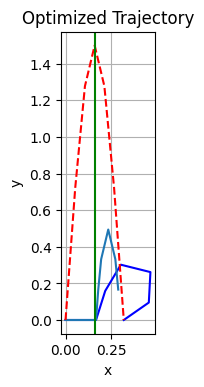

In [137]:
plt.figure(dpi=100,facecolor='w')
plt.plot(opt[0,:],opt[1,:], color = 'b')
x_check = np.linspace(0,1/pi,nt)
y_check = f(x_check)
# print(np.median(x_check))

plt.plot(x_sim, y_sim)
plt.title('Optimized Trajectory')
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(x_check, y_check, linestyle='--', color = 'r')
plt.axvline(np.median(x_check), color='g', label='axvline - full height')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [138]:
dx_check = x_check[1:] - x_check[0:-1]
dy_check = y_check[1:] - y_check[0:-1]
squ_dcheck = np.sum(dx_check**2 + dy_check**2)

dx_sim = x_sim[1:] - x_sim[0:-1]
dy_sim = y_sim[1:] - y_sim[0:-1]
squ_dsim = np.sum(dx_sim**2 + dy_sim**2)

xop = opt[0,:]
yop = opt[1,:]
dx_opt = xop[1:] - xop[0:-1]
dy_opt = yop[1:] - yop[0:-1]
squ_dopt = np.sum(dx_opt**2 + dy_opt**2)

print(squ_dcheck)
print(squ_dopt)
print(squ_dsim)

1.7761461231996494
0.1666666666666729
0.16666666666666663


In [139]:
##################
############
#######DEBUG
print('x_optimized', opt[0,:])
print('y_optimized', opt[1,:])
print('theta_optimized', opt[2,:])
print('u_optimized', opt[3,:])
###check elastic energy at each point
print('elastic energy at each point', 0.5*opt[-1,:]**2*dt)
print('----------------------')
print('Observed from elastic energy at each point, not all point has its smallest elastic energy')
print(dt)

x_optimized [0.         0.16666667 0.21685274 0.30217248 0.46386853 0.45506327
 0.31830989]
y_optimized [ 0.00000000e+00  0.00000000e+00  1.58931231e-01  3.02103570e-01
  2.61703474e-01  9.52695673e-02 -3.33066744e-16]
theta_optimized [ 0.          1.26493313  1.03337972 -0.24483946 -1.62365248 -2.53311696
 -1.49747189]
u_optimized [ 7.58959877 -1.38932045 -7.66931507 -8.27287815 -5.45678683  6.21387039
  0.        ]
elastic energy at each point [4.80016746 0.16085094 4.90153281 5.70337607 2.48137687 3.2176821
 0.        ]
----------------------
Observed from elastic energy at each point, not all point has its smallest elastic energy
0.16666666666666666


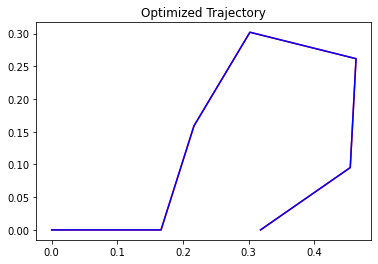

0.16666666666666666


In [140]:
def check_trac(opt):
#     u_opt = opt[-1,0:-1]
    u_opt = opt[-1,:]
    x_opt = opt[0,:]
    y_opt = opt[1,:]
    theta_opt = opt[2,:]
    q1_opt = np.zeros(len(x_opt))
    q2_opt = np.zeros(len(y_opt))
    q3_opt = np.zeros(len(theta_opt))
    for i in range(nt-1):
        if i == 0:
            q1_opt[0], q2_opt[0], q3_opt[0] = x_opt[0], y_opt[0], theta_opt[0]
    

        q1_opt[i+1] = q1_opt[i] +  dt*cos(q3_opt[i])
        q2_opt[i+1] = q2_opt[i] +  dt*sin(q3_opt[i])
        q3_opt[i+1] = q3_opt[i] + dt*u_opt[i]
        

        
    return q1_opt, q2_opt, q3_opt, u_opt

q1_opt, q2_opt, q3_opt, q4_opt = check_trac(opt)
plt.plot(q1_opt, q2_opt, color = 'r')
plt.plot(opt[0,:], opt[1,:], color = 'b')
plt.title('Optimized Trajectory')
plt.show()
print(dt)
    

In [141]:
print(q3_opt)
print(q4_opt)
print(dt)

[ 0.          1.26493313  1.03337972 -0.24483946 -1.62365248 -2.53311696
 -1.49747189]
[ 7.58959877 -1.38932045 -7.66931507 -8.27287815 -5.45678683  6.21387039
  0.        ]
0.16666666666666666


In [142]:
# q1_opt = q1_opt.reshape((1,nt))
# q2_opt = q2_opt.reshape((1,nt))
# q3_opt = q3_opt.reshape((1,nt))
# u_opt = u_opt.reshape((1,nt))
# qs_opt = np.vstack((q1_opt,q2_opt,q3_opt,u_opt))
# num = system_dynamics(qs_opt)
# print(num)

In [143]:
u_opt = opt[3,:]
E_after = dt*0.5*np.sum(u_opt**2)
print('energy after optimization and before optimization', E_after, E_before)

energy after optimization and before optimization 21.26498625404713 28.279492123420173


In [144]:
###### left hand side qdot
xdot = np.zeros((1,nt))
for i in range(len(x) - 1):
    xdot[i+1] = (x[i+1] - x[i])
    
ydot = np.zeros((1,nt))
for i in range(len(y) - 1):
    ydot[i+1] = (y[i+1] - y[i])
    
thetadot = np.zeros((1,nt))
for i in range(len(theta) - 1):
    thetadot[i+1] = theta[i+1] - theta[i]
xdot[-1] = 0
ydot[-1] = 0
thetadot[-1] = 0

In [145]:
##################
#right hand side
xdot_right = np.zeros((1,nt))
for i in range(nt):
    xdot_right[:,i] = cos(theta[:,i])

ydot_right = np.zeros((1,nt))
for i in range(nt-1):
    ydot_right[:,i] = sin(theta[:,i])
thetadot_right = u_opt


In [146]:
# ##################
# #compute the mean squared error
# MSE_x = np.sum((np.square(np.subtract(xdot, dt*xdot_right))).mean())
# MSE_y = np.sum((np.square(np.subtract(ydot, dt*ydot_right))).mean())
# MSE_theta = np.sum((np.square(np.subtract(thetadot, dt*thetadot_right))).mean())
# # MSE_x = np.sum((np.square(np.subtract(xdot, dt*xdot_right))))
# # MSE_y = np.sum((np.square(np.subtract(ydot, dt*ydot_right))))
# # MSE_theta = np.sum((np.square(np.subtract(thetadot, dt*thetadot_right))))

In [147]:
# print(MSE_x)
# print(MSE_y)
# print(MSE_theta)
# print(MSE_x + MSE_y + MSE_theta)